# Benchmarking spike sorters


To benchmark the spike sorting algorithms, one of the easiest option is to design artifical dataset, in order to have a full control on what is created, and to have a proper "ground truth" to compare with. 

To do so, MEArec (https://github.com/alejoe91/MEArec) is a python package that can help you to generate such artificial datasets. Basically, given some templates and a probe layout, the software will generate traces that can later be used for benchmarking the sorting algorithms. In this notebook, we wont have time to cover all the possibilities offered by MEArec. While you are strongly encouraged to have a look to the API, you should have downloaded from the google drive link an already generated dataset. Feel free to ask if questions.

The comparison between different sorters can be tedious, since every one of them has a different file format. However, spikeinterface can act as a universal wrapper allowing you to launch and read the results of the sorters. Moreover, spikeinterface comes with numerous analysis functions that will allow you to quickly assess the quality of a spike sorting, and compute quality metrics with respect to the Ground Truth that have been generated

The only file needed here will be "recordings_Neuronexus-32_static.h5", that we have generated for this notebook

In [1]:
%matplotlib widget

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.full as si

## Step 1 : load the MEArec ground truth recordings

In [3]:
basedir = Path('.')
filename = basedir / 'recordings_Neuronexus-32_static.h5'
recording, sorting_gt = si.read_mearec(filename)

In [4]:
recording

MEArecRecordingExtractor: 32 channels - 1 segments - 32.0kHz - 300.000s
  file_path: recordings_Neuronexus-32_static.h5

In [5]:
sorting_gt

MEArecSortingExtractor: 25 units - 1 segments - 32.0kHz
  file_path: recordings_Neuronexus-32_static.h5

## Step 2 : open and plot the signals and the spikes from our ground truth

In [8]:
waveforms_gt = si.extract_waveforms(recording, sorting_gt, basedir / 'waveforms',
                                 ms_before=1.5, ms_after=1.5, load_if_exists=True)
si.plot_unit_templates(waveforms_gt, backend='ipywidgets')


/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/traitlets/traitlets.py:588: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  silent = bool(old_value == new_value)


AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [9]:
si.plot_timeseries(recording, time_range=(5,5.1), backend='ipywidgets')

AppLayout(children=(VBox(children=(FloatSlider(value=5.0, continuous_update=False, description='time:', layout…

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


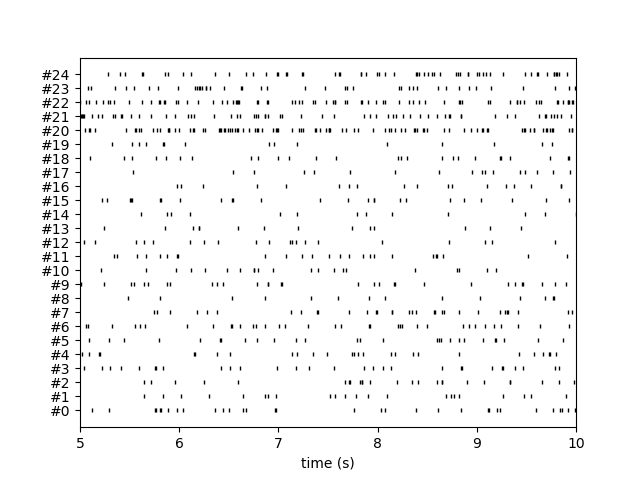

In [10]:
# We can also look at spikes
si.plot_rasters(sorting_gt, time_range=(5,10))

**Exercice**

Could you plot the waveforms density map for the first 5 GT neurons?

## Step 3 : run several sorters on GT recording

With spikeinterface, launching a spike sorting algorithm is easy. You simply need to do use the run_sorter command. Assuming we want to save every sorting into a specific folder, with a name dedicated to every sorter, we can simply do

In [11]:
sorting_sc2 = si.run_sorter('spykingcircus2', recording, output_folder=basedir / 'spykingcircus2')
sorting_tdc = si.run_sorter('tridesclous', recording, output_folder=basedir / 'tridesclous')

# Note that the sorter list can includes 'kilosort', 'herdingspikes', ... See spikeinterface wrapper for more info

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/tridesclous/dataio.py:175: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v1 = distutils.version.LooseVersion(tridesclous_version).version
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/tridesclous/dataio.py:176: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v2 = distutils.version.LooseVersion(self.info['tridesclous_version']).version
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/pierre/anaconda3/envs/circus/lib/py

**Exercice**

For those that have installed spykingcircus, or that have the docker version of Kilosort, you can try to launch it by tweaking the run_sorter command. Otherwise, just add the sorting obtained after launching tridesclous2, integrated within spikeinterface

Once a given sorter has been launched, you can load its results easily

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


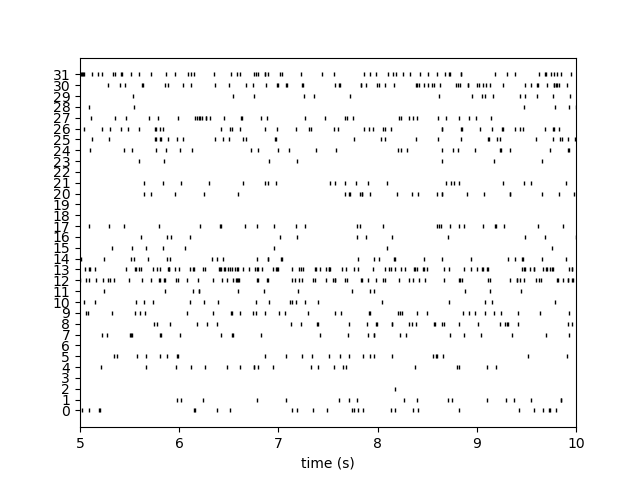

In [20]:
# We can also look at spikes
si.plot_rasters(sorting_sc2, time_range=(5,10))

You just noticed how easy it is to run several sorters on a given recording. But what about comparisons? Now we would like to be able to quantify how good these sorters are, with respect to the ground truth units that have been created. 

## Step 4 : run comparison and plot agreement matrix for one sorter

Once we have a given spike sorting, we can always compare it to its ground-truth, via the comparison object offered by spikeinterface

In [21]:
comp_sc2 = si.compare_sorter_to_ground_truth(sorting_gt, sorting_sc2)
comp_tdc = si.compare_sorter_to_ground_truth(sorting_gt, sorting_tdc)


Such a comparison object can immediatly tell us how many units are found, what are the errors rates, and much more

In [23]:
comp_sc2.agreement_scores # TO view the quality score between units

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
#0,0.001591,0.003185,0.001936,0.000000,0.002723,0.001365,0.000000,0.000677,0.000597,0.001421,...,0.0,0.001069,0.001736,0.998768,0.002475,0.003162,0.000000,0.000350,0.003120,0.003309
#1,0.002678,0.000746,0.002091,0.000000,0.001434,0.001080,0.000000,0.001071,0.001565,0.002380,...,0.0,0.000000,0.001466,0.001619,0.002983,0.001869,0.001069,0.000370,0.003021,0.002503
#2,0.003094,0.001368,0.000000,0.000579,0.001978,0.004643,0.000000,0.002300,0.001453,0.001939,...,0.0,0.000509,0.001008,0.001199,0.001617,0.002210,0.006648,0.002717,0.003429,0.003428
#3,0.001443,0.004134,0.002094,0.000000,0.001839,0.001229,0.000000,0.002751,0.003001,0.003653,...,0.0,0.000000,0.004069,0.001965,0.588235,0.002103,0.000000,0.000314,0.004163,0.003133
#4,0.997377,0.002568,0.000508,0.000000,0.001408,0.006394,0.000000,0.003515,0.001849,0.000878,...,0.0,0.000000,0.002161,0.001593,0.002106,0.002079,0.001562,0.002911,0.001494,0.002835
#5,0.002693,0.002633,0.002109,0.000000,0.002889,0.003993,0.000000,0.001437,0.000943,0.002091,...,0.0,0.000000,0.001106,0.001954,0.001280,0.002817,0.000000,0.002610,0.004551,0.002869
#6,0.001169,0.002576,0.003848,0.000000,0.002176,0.002496,0.000000,0.000928,0.001103,0.992138,...,0.0,0.000465,0.003172,0.001706,0.002927,0.002124,0.000434,0.000000,0.003669,0.004324
#7,0.001850,0.002389,0.002770,0.000000,0.001972,0.002310,0.000000,0.001965,0.994804,0.001381,...,0.0,0.000000,0.002013,0.000598,0.003437,0.001322,0.000941,0.001353,0.002521,0.003766
#8,0.002458,0.002366,0.003388,0.000000,0.003404,0.001516,0.000000,0.001880,0.003937,0.001861,...,0.0,0.001267,0.002320,0.002036,0.402948,0.001932,0.000577,0.000780,0.001743,0.002567
#9,0.002572,0.001428,0.000981,0.000000,0.003440,0.002415,0.000000,0.002396,0.001506,0.000859,...,0.0,0.000543,0.001052,0.001557,0.002282,0.003411,0.004022,0.002481,0.002582,0.003501


/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


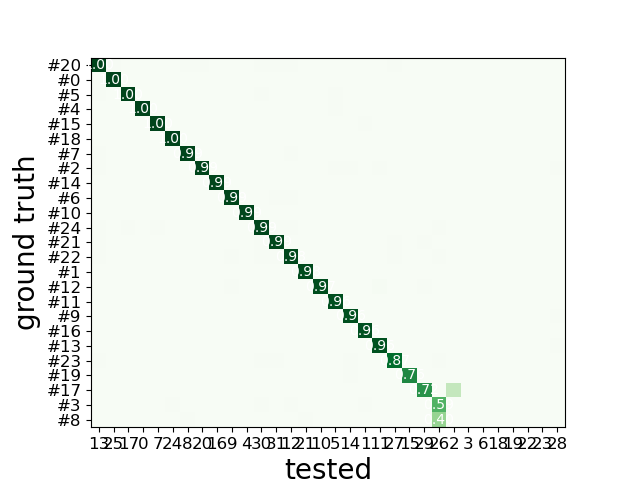

In [24]:
si.plot_agreement_matrix(comp_sc2)

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


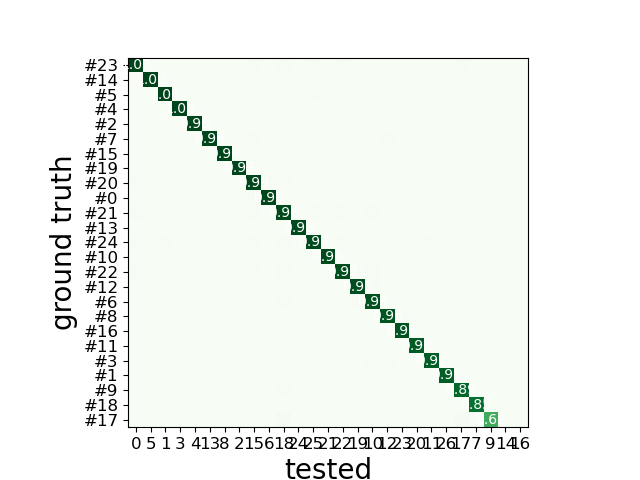

In [25]:
si.plot_agreement_matrix(comp_tdc)

## Step 5 : run comparisons accross sorters (without the study object)

What if we have several spike sorting algorithms, and want to quickly compare each of them? The comparison could be performed on a single recording, and/or or various recordings at once, to get a more global comparison. 

Let's first start with the simple case of a single comparison, on a single recording. As said, you can easily, with spikeinterface, compare the results accross sorters. To do so, the simplest option is to launch the sorters individually, and compare the results via a so-called aggrement study

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


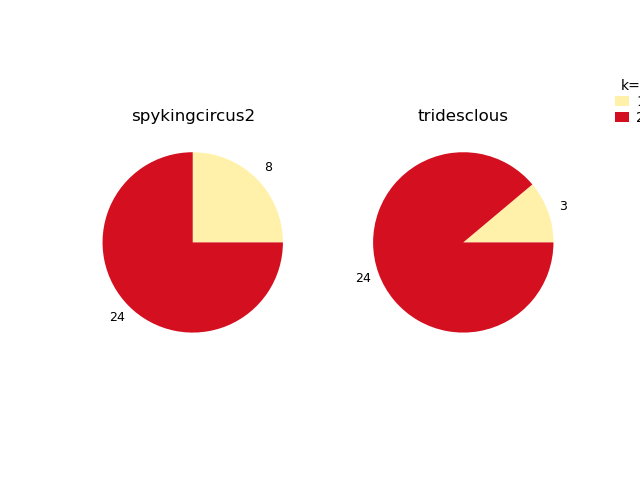

In [27]:
comp = si.compare_multiple_sorters([sorting_sc2, sorting_tdc], ['spykingcircus2', 'tridesclous'])
si.plot_multicomp_agreement_by_sorter(comp)

## Step 5 : run comparisons accross sorters (with the study object)

As mentionned before, the comparison between sorters could also be done in a more general manner via the study object. The study can compare several sorters not only on a single, but on multiple recordings at once. 

Since we gave you only one recordings, let's try to compare how sorters behave when launched twice on the same recording

In [32]:
#Now we can create the dictionary of all recordings used by the study
gt_dict = {'rec0' : (recording, sorting_gt), 'rec1' : (recording, sorting_gt)}

#And create a study object to compare them
study = si.GroundTruthStudy.create('study', gt_dict, n_jobs=-1, chunk_memory='1G', progress_bar=True)

write_binary_recording with n_jobs = 12 and chunk_size = 7812500


write_binary_recording:   0%|          | 0/2 [00:00<?, ?it/s]

write_binary_recording with n_jobs = 12 and chunk_size = 7812500


write_binary_recording:   0%|          | 0/2 [00:00<?, ?it/s]

The study object is gathering all the recordings in the specified folder, this is why we need to specify chunk_memory and number of jobs used to copy evertyhing. Now that we have the study created, we can easily launch it on several sorters, either for all recordings or for a subset

In [35]:
study.run_sorters(['spykingcircus2', 'tridesclous'])

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/tridesclous/dataio.py:175: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v1 = distutils.version.LooseVersion(tridesclous_version).version
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/tridesclous/dataio.py:176: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v2 = distutils.version.LooseVersion(self.info['tridesclous_version']).version
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/tridesclous/dataio.py:175: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v1 = distutils.version.LooseVersion(tridesclous_version).version
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/tridesclous/dataio.py:176: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  v2 = distutils.version.LooseVersion(self.info['tride

Now that the study has been ran, we need to perform the comparisons between all sorters and the ground truths. Note that if we have an exhaustive ground truth, i.e. if we have a full description of our artificial recordings with the sorting (which is the case here), then it must be specified. This will enhance the quality metrics and provide more information

In [36]:
study.run_comparisons(exhaustive_gt=True)

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/

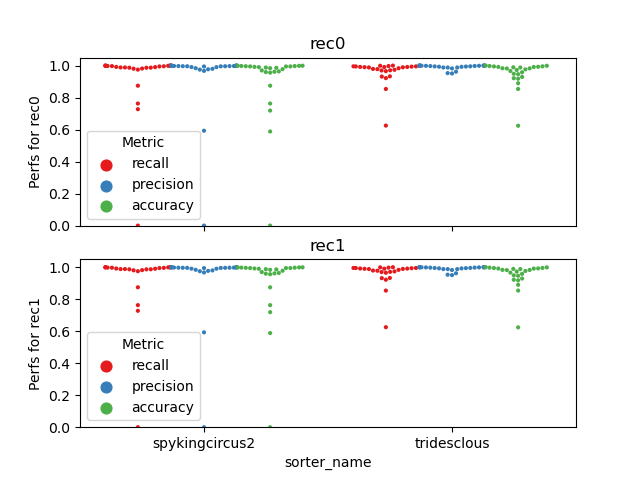

In [38]:
si.plot_gt_study_performances(study)

In [39]:
study.aggregate_run_times()

run_time
rec_name sorter_name               
rec0     tridesclous      84.434383
         spykingcircus2   88.333241
rec1     tridesclous     101.172932
         spykingcircus2   97.493600

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


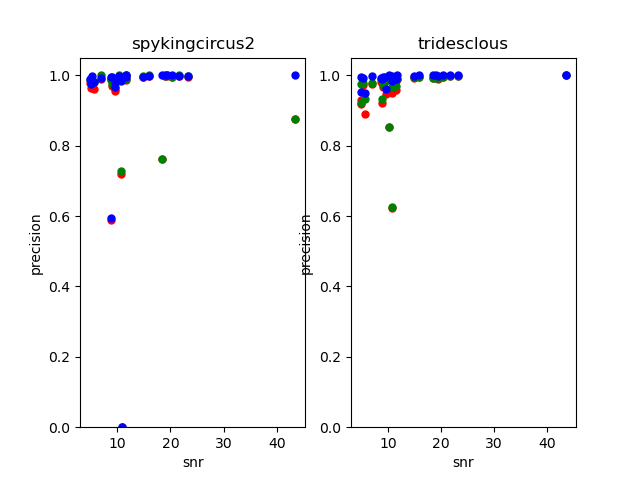

In [53]:
sorters = ['spykingcircus2', 'tridesclous']
fig, axes = plt.subplots(1, len(sorters))
metrics = si.compute_quality_metrics(waveforms_gt, metric_names=['snr'], load_if_exists=True)

for count, sorter in enumerate(sorters):
    key = ('rec0', sorter)
    ax = axes[count]
    ax.set_title(sorter)
    si.plot_sorting_performance(study.comparisons[key], metrics, performance_name='accuracy', metric_name='snr', ax=ax, color='r')
    si.plot_sorting_performance(study.comparisons[key], metrics, performance_name='recall', metric_name='snr', ax=ax, color='g')
    si.plot_sorting_performance(study.comparisons[key], metrics, performance_name='precision', metric_name='snr', ax=ax, color='b')        

## Step 6 : Challenging the collisions

In [58]:
comp_sc = si.CollisionGTComparison(sorting_gt, sorting_sc2)
comp_tdc = si.CollisionGTComparison(sorting_gt, sorting_tdc)


In [56]:
templates = waveforms_gt.get_all_templates()

/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)
/home/pierre/anaconda3/envs/circus/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:477: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  super(Widget, self).__init__(**kwargs)


AttributeError: 'GroundTruthComparison' object has no attribute 'bins'

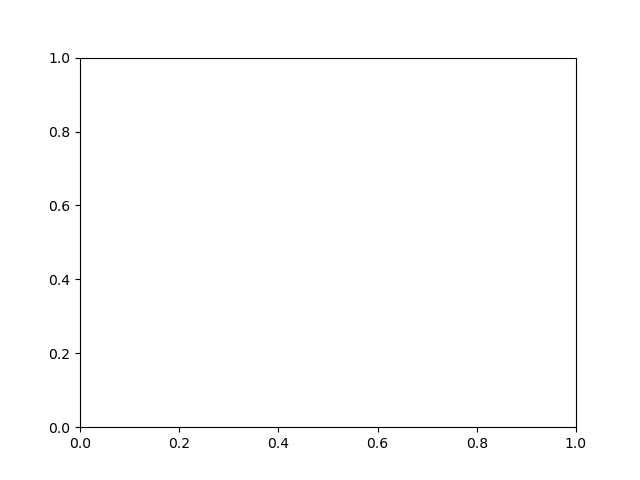

In [57]:
si.plot_comparison_collision_by_similarity(comp_sc2, templates, mode='lines')
si.plot_comparison_collision_by_similarity(comp_tdc, templates, mode='lines')
